<a href="https://colab.research.google.com/github/froestiago/pytorch-course/blob/main/02_neural_network__classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network Classification with PyTorch

In [81]:
import torch
import numpy as np
import torch.nn as nn
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

## 1. Data generation

In [82]:
# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

In [83]:
print(f'Fiirst 5 samples of X:\n {X[:5]}')
print(f'Fiirst 5 samples of y:\n {y[:5]}')

Fiirst 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Fiirst 5 samples of y:
 [1 1 1 1 0]


In [84]:
# Make DataFrame with pandas
import pandas as pd

circles = pd.DataFrame({'X_1': X[:, 0],
                        'X_2': X[:, 1],
                        'label': y})

circles.head(10)

,X_1,X_2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


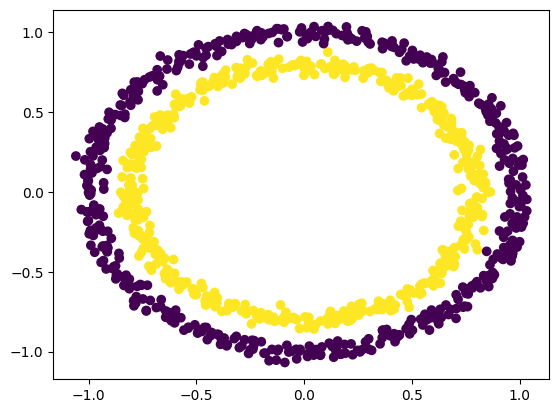

In [85]:
# Visualize

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y)

## 1.1 Check input and output shapes

In [86]:
print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (1000, 2)
y.shape: (1000,)


In [87]:
# from array to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# creating train & test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)

In [88]:
print(f'len(X_train): {len(X_train)}')
print(f'len(X_test): {len(X_test)}')
print(f'len(y_train): {len(y_train)}')
print(f'len(y_test): {len(y_test)}')

len(X_train): 800
len(X_test): 200
len(y_train): 800
len(y_test): 200


## 2. Building a model

let's build a model to classify out blue and red dots

To do so, we want to:
1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Define loss function and optimizer
4. Create a training and test loop

In [89]:
# 1. Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [90]:
# 2. Construc a model

class CircleModel_V0(nn.Module):
  def __init__(self):
    super().__init__()
    # create 2 linear layers
    self.layer_1 = nn.Linear(in_features = 2,
                             out_features = 5)

    self.layer_2 = nn.Linear(in_features = 5,
                             out_features = 1)

  def forward(self, x : torch.Tensor) -> torch.Tensor:
    output = self.layer_1(x)
    output = self.layer_2(x)
    return output

In [91]:
model_0 = CircleModel_V0().to(device)
print(model_0)

print(next(model_0.parameters()).device)

CircleModel_V0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)
cuda:0


In [92]:
# replicating the model above using nn.Sequential

# class CircleModel_V0(nn.Module):
#   def __init__(self):
#     super(CircleModel_V0, self).__init__()

#     self.two_linear_layers = nn.Sequential(
#       nn.Linear(in_features = 2, out_features = 5),
#       nn.Linear(in_features = 5, out_features = 1)
#     )

#     def forward(self, x):
#         return self.two_linear_layers(x)

# model_0 = CircleModel_V0()
# print(model_0)
# model_0.to(device)

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [93]:
print(model_0.state_dict())

OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
        [ 0.4691, -0.5582],
        [-0.3260, -0.1997],
        [-0.4252,  0.0667],
        [-0.6984,  0.6386]], device='cuda:0')), ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')), ('1.weight', tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')), ('1.bias', tensor([-0.1213], device='cuda:0'))])


In [94]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")


Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Loss functions are different for each task, classification and regression
which loss functions or optimizer should you use?



In [95]:
# Set up loss function

loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activation function built-in

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [96]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward (backpropagation)
5. Optimizer step (gradient descent)


### 3.1 Going from raw logits -> predictions probabilities -> prediction labels

In [97]:
# view the first 5 outputs of the foward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
print(y_logits)

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')


In [98]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [99]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities

y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)
print(torch.round(y_pred_probs))

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')
tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')


For our prediction probability values, we need to perform a range-style rounding on them:

 - `y_pred_probs` >= 0.5 `y=1` (class 1)
 - `y_pred_probs` < 0.5 `y=0` (class 0)

In [100]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

## 3.2 Building training loop

In [101]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  # Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  # 2. Caculate loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                         y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer Step (gradient descent)
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    # Print what's going onononon
    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69796 | Acc: 51.88% | Test Loss: 0.69440 Test acc: 58.00%
Epoch: 10 | Loss: 0.69590 | Acc: 51.25% | Test Loss: 0.69305 Test acc: 53.00%
Epoch: 20 | Loss: 0.69490 | Acc: 51.62% | Test Loss: 0.69254 Test acc: 49.50%
Epoch: 30 | Loss: 0.69435 | Acc: 51.12% | Test Loss: 0.69236 Test acc: 49.50%
Epoch: 40 | Loss: 0.69401 | Acc: 50.88% | Test Loss: 0.69232 Test acc: 51.00%
Epoch: 50 | Loss: 0.69378 | Acc: 50.25% | Test Loss: 0.69234 Test acc: 50.00%
Epoch: 60 | Loss: 0.69362 | Acc: 50.00% | Test Loss: 0.69239 Test acc: 51.50%
Epoch: 70 | Loss: 0.69351 | Acc: 50.25% | Test Loss: 0.69246 Test acc: 51.00%
Epoch: 80 | Loss: 0.69342 | Acc: 49.88% | Test Loss: 0.69254 Test acc: 50.00%
Epoch: 90 | Loss: 0.69336 | Acc: 49.88% | Test Loss: 0.69262 Test acc: 53.00%


## 4. Make predictions and evaluate the model

Visualize!

In [103]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

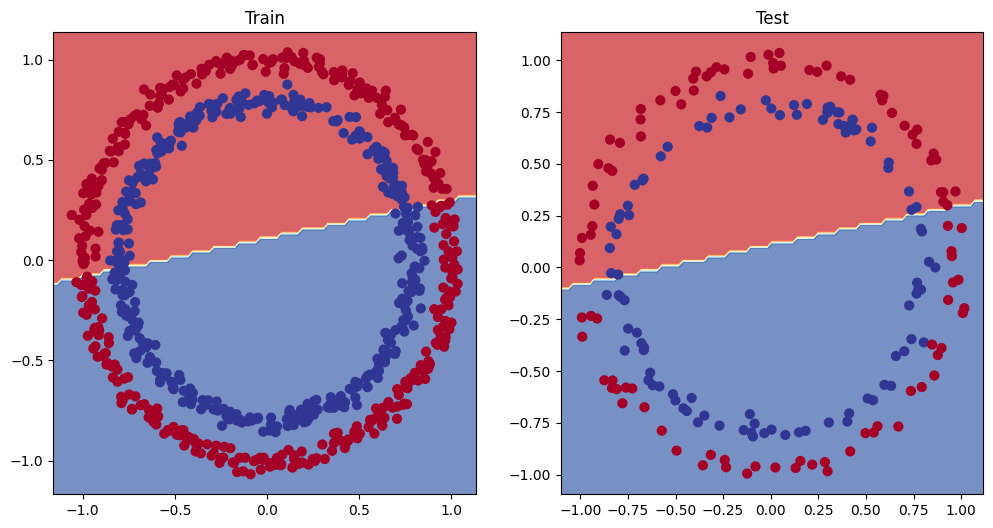

In [104]:
# Plot decision boundary of the model

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)